### Word2Vec

https://www.tensorflow.org/tutorials/word2vec

In [1]:
"""Importing the required packages"""
import random
import collections
import math
import os
import zipfile
import time
import re 

import numpy as np
import tensorflow as tf

from matplotlib import pylab
%matplotlib inline

from six.moves import range
from six.moves.urllib.request import urlretrieve

from tensorflow.contrib.tensorboard.plugins import projector
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [2]:
"""Make sure the dataset link is copied correctly"""

dataset_link = 'http://mattmahoney.net/dc/'
zip_file = 'text8.zip'

def data_download(zip_file):
    """Downloading the required file"""
    if not os.path.exists(zip_file):
        zip_file, _ = urlretrieve(dataset_link + zip_file, zip_file)
        print('File downloaded successfully!')
    return None

data_download(zip_file)

In [3]:
"""Extracting the dataset in separate folder"""
extracted_folder = 'dataset'

if not os.path.isdir(extracted_folder):
    with zipfile.ZipFile(zip_file) as zf:
        zf.extractall(extracted_folder)

In [4]:
with open('dataset/text8') as ft_ :
    full_text = ft_.read()

In [5]:
def text_processing(ft8_text):
    """Replacing punctuation marks with tokens"""
    ft8_text = ft8_text.lower()
    ft8_text = ft8_text.replace('.', ' <period> ')
    ft8_text = ft8_text.replace(',', ' <comma> ')
    ft8_text = ft8_text.replace('"', ' <quotation> ')
    ft8_text = ft8_text.replace(';', ' <semicolon> ')
    ft8_text = ft8_text.replace('!', ' <exclamation> ')
    ft8_text = ft8_text.replace('?', ' <question> ')
    ft8_text = ft8_text.replace('(', ' <paren_l> ')
    ft8_text = ft8_text.replace(')', ' <paren_r> ')
    ft8_text = ft8_text.replace('--', ' <hyphen> ')
    ft8_text = ft8_text.replace(':', ' <colon> ')
    ft8_text_tokens = ft8_text.split()
    
    return ft8_text_tokens

In [6]:
ft_tokens = text_processing(full_text)
"""Shortlisting words with frequency more than 7"""
word_cnt = collections.Counter(ft_tokens)
shortlisted_words = [w for w in ft_tokens if word_cnt[w] > 7 ]

In [7]:
def dict_creation(shortlisted_words):
    """The function creates a dictionary of the words present in dataset along with their frequency order"""
    counts = collections.Counter(shortlisted_words)
    vocabulary = sorted(counts, key=counts.get, reverse=True)
    rev_dictionary_ = {ii: word for ii, word in enumerate(vocabulary)}
    dictionary_ = {word: ii for ii, word in rev_dictionary_.items()}
    return dictionary_, rev_dictionary_

In [8]:
dictionary_, rev_dictionary_ = dict_creation(shortlisted_words)
words_cnt = [dictionary_[word] for word in shortlisted_words]

### CBOW

In [11]:
data_index = 0

def cbow_batch_creation(batch_length, word_window):
    """The function creates a batch with the list of the label words and list of their corresponding words in the context of
    the label word."""
    global data_index
    """Pulling out the centered label word, and its next word_window count of surrounding words
    word_window : window of words on either side of the center word
    relevant_words : length of the total words to be picked in a single batch, 
            including the center word and the word_window words on both sides
    Format :  [ word_window ... target ... word_window ] """
    relevant_words = 2 * word_window + 1 

    batch = np.ndarray(shape=(batch_length,relevant_words-1), dtype=np.int32)
    label_ = np.ndarray(shape=(batch_length, 1), dtype=np.int32)

    buffer = collections.deque(maxlen=relevant_words)   # Queue to add/pop

    #Selecting the words of length 'relevant_words' from the starting index 
    for _ in range(relevant_words):
        buffer.append(words_cnt[data_index])
        data_index = (data_index + 1) % len(words_cnt)

    for i in range(batch_length):
        target = word_window  # Center word as the label
        target_to_avoid = [ word_window ] # Excluding the label, and selecting only the surrounding words

        # add selected target to avoid_list for next time
        col_idx = 0
        for j in range(relevant_words):
            if j==relevant_words//2:
                continue
            batch[i,col_idx] = buffer[j] # Iterating till the middle element for window_size length
            col_idx += 1
        label_[i, 0] = buffer[target]

        buffer.append(words_cnt[data_index])
        data_index = (data_index + 1) % len(words_cnt)

    assert batch.shape[0]==batch_length and batch.shape[1]== relevant_words-1
    return batch, label_


In [12]:
for num_skips, word_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, label_ = cbow_batch_creation(batch_length=8, word_window=word_window)
    print('\nwith num_skips = %d and word_window = %d:' % (num_skips, word_window))
    
    print('    batch:', [[rev_dictionary_[bii] for bii in bi] for bi in batch])
    print('    label_:', [rev_dictionary_[li] for li in label_.reshape(8)])


with num_skips = 2 and word_window = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['a', 'of'], ['term', 'abuse'], ['of', 'first'], ['abuse', 'used'], ['first', 'against']]
    label_: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with num_skips = 4 and word_window = 2:
    batch: [['anarchism', 'originated', 'a', 'term'], ['originated', 'as', 'term', 'of'], ['as', 'a', 'of', 'abuse'], ['a', 'term', 'abuse', 'first'], ['term', 'of', 'first', 'used'], ['of', 'abuse', 'used', 'against'], ['abuse', 'first', 'against', 'early'], ['first', 'used', 'early', 'working']]
    label_: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [13]:
num_steps = 100001
"""Initialzing :
   # 128 is the length of the batch considered for CBOW
   # 128 is the word embedding vector size
   # Considering 1 word on both sides of the center label words
   # Consider the center label word 2 times to create the batches
"""
batch_length = 128
embedding_size = 128
skip_window = 1
num_skips = 2


In [14]:
"""The below code performs the following operations :
 # Performing validation here by making use of a random selection of 16 words from the dictionary of desired size
 # Selecting 8 words randomly from range of 1000    
 # Using the cosine distance to calculate the similarity between the words 
"""

tf_cbow_graph = tf.Graph()

with tf_cbow_graph.as_default():
    validation_cnt = 16
    validation_dict = 100
    
    validation_words = np.array(random.sample(range(validation_dict), validation_cnt//2))
    validation_words = np.append(validation_words,random.sample(range(1000,1000+validation_dict), validation_cnt//2))

    train_dataset = tf.placeholder(tf.int32, shape=[batch_length,2*skip_window])
    train_labels = tf.placeholder(tf.int32, shape=[batch_length, 1])
    validation_data = tf.constant(validation_words, dtype=tf.int32)


In [16]:
"""
Embeddings for all the words present in the vocabulary
"""
with tf_cbow_graph.as_default() :
    vocabulary_size = len(rev_dictionary_)
    
    word_embed = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))

    # Averaging embeddings accross the full context into a single embedding layer
    context_embeddings = []
    for i in range(2*skip_window):
        context_embeddings.append(tf.nn.embedding_lookup(word_embed, train_dataset[:,i]))

    embedding =  tf.reduce_mean(tf.stack(axis=0,values=context_embeddings),0,keep_dims=False)

the below function optimizes the weights, biases and word embeddings

In [17]:
"""The code includes the following  :
 # Initializing weights and bias to be used in the softmax layer
 # Loss function calculation using the Negative Sampling
 # Usage of AdaGrad Optimizer
 # Negative sampling on 64 words, to be included in the loss function
"""
with tf_cbow_graph.as_default() :
    sf_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size],
                     stddev=1.0 / math.sqrt(embedding_size)))
    sf_bias = tf.Variable(tf.zeros([vocabulary_size]))

    loss_fn = tf.nn.sampled_softmax_loss(weights=sf_weights, biases=sf_bias, inputs=embedding,
                           labels=train_labels, num_sampled=64, num_classes=vocabulary_size)
    cost_fn = tf.reduce_mean(loss_fn)
    """Using AdaGrad as optimizer"""
    optim = tf.train.AdagradOptimizer(1.0).minimize(cost_fn)

In [18]:
""" 
Using the cosine distance to calculate the similarity between the batches and embeddings of other words 
"""
with tf_cbow_graph.as_default() :
    
    normalization_embed = word_embed / tf.sqrt(tf.reduce_sum(tf.square(word_embed), 1, keep_dims=True))
    validation_embed = tf.nn.embedding_lookup(normalization_embed, validation_data)
    word_similarity = tf.matmul(validation_embed, tf.transpose(normalization_embed))


In [30]:
with tf.Session(graph=tf_cbow_graph) as sess:
    sess.run(tf.global_variables_initializer())

    avg_loss = 0
    for step in range(num_steps):
        batch_words, batch_label_ = cbow_batch_creation(batch_length, skip_window)
        _, l = sess.run([optim, loss_fn], feed_dict={train_dataset : batch_words, train_labels : batch_label_ })
        avg_loss += l
        if step % 2000 == 0 :
            if step > 0 :
                avg_loss = avg_loss / 2000
            print('Average loss at step %d: %f' % (step, np.mean(avg_loss) )) 
            avg_loss = 0
        
        if step % 10000 == 0:
            sim = word_similarity.eval()
            for i in range(validation_cnt):
                valid_word = rev_dictionary_[validation_words[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = 'Nearest to %s:' % valid_word
                for k in range(top_k):
                    close_word = rev_dictionary_[nearest[k]]
                    log = '%s %s,' % (log, close_word)
                print(log)
    final_embeddings = normalization_embed.eval()

Average loss at step 0: 7.807584
Nearest to can: ambients, darpa, herculaneum, chocolate, alloted, bards, coyote, analogy,
Nearest to or: state, stopping, falls, markus, bellarmine, bitrates, snub, headless,
Nearest to will: cosmologies, valdemar, feeding, synergies, fence, helps, zadok, neoplatonist,
Nearest to known: rationale, fibres, nino, logging, motherboards, richelieu, invaded, fulfill,
Nearest to no: rook, logitech, landscaping, melee, eisenman, ecuadorian, warrior, napoli,
Nearest to these: swinging, zwicker, crusader, acuff, ivb, karakoram, mtu, egg,
Nearest to not: battled, grieg, denominators, kyi, paragliding, loxodonta, ceases, expose,
Nearest to one: inconsistencies, dada, ih, gallup, ayya, float, subsumed, aires,
Nearest to woman: philibert, lug, breakthroughs, ric, raman, uzziah, cops, chalk,
Nearest to alternative: kendo, tux, girls, filmmakers, cortes, akio, length, grayson,
Nearest to versions: helvetii, moody, denning, latvijas, subscripts, unamended, anodes, unac

Average loss at step 52000: 2.872307
Average loss at step 54000: 2.875248
Average loss at step 56000: 2.785064
Average loss at step 58000: 2.800782
Average loss at step 60000: 2.801480
Nearest to can: may, could, will, must, cannot, would, should, might,
Nearest to or: and, than, woodside, dhimmi, missing, niv, mandy, proactive,
Nearest to will: would, could, can, may, must, should, might, cannot,
Nearest to known: regarded, defined, individualistic, viewed, possible, used, seen, explained,
Nearest to no: any, warrior, everything, little, phenomenalism, bowden, brushing, qa,
Nearest to these: such, several, some, various, those, many, both, they,
Nearest to not: never, always, actually, still, typically, usually, diligence, now,
Nearest to one: two, six, seven, five, result, four, nine, eight,
Nearest to woman: person, philibert, cvbg, man, calandria, plotinus, acheron, reign,
Nearest to alternative: individual, tux, girls, important, kendo, circumvent, online, given,
Nearest to versio

Using the vector representation of 250 words to show their distribution across the new vector space

In [31]:
num_points = 250

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
embeddings_2d = tsne.fit_transform(final_embeddings[1:num_points+1, :])

In [36]:
def cbow_plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(12,12))
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points', ha='right', va='bottom')
    pylab.show()

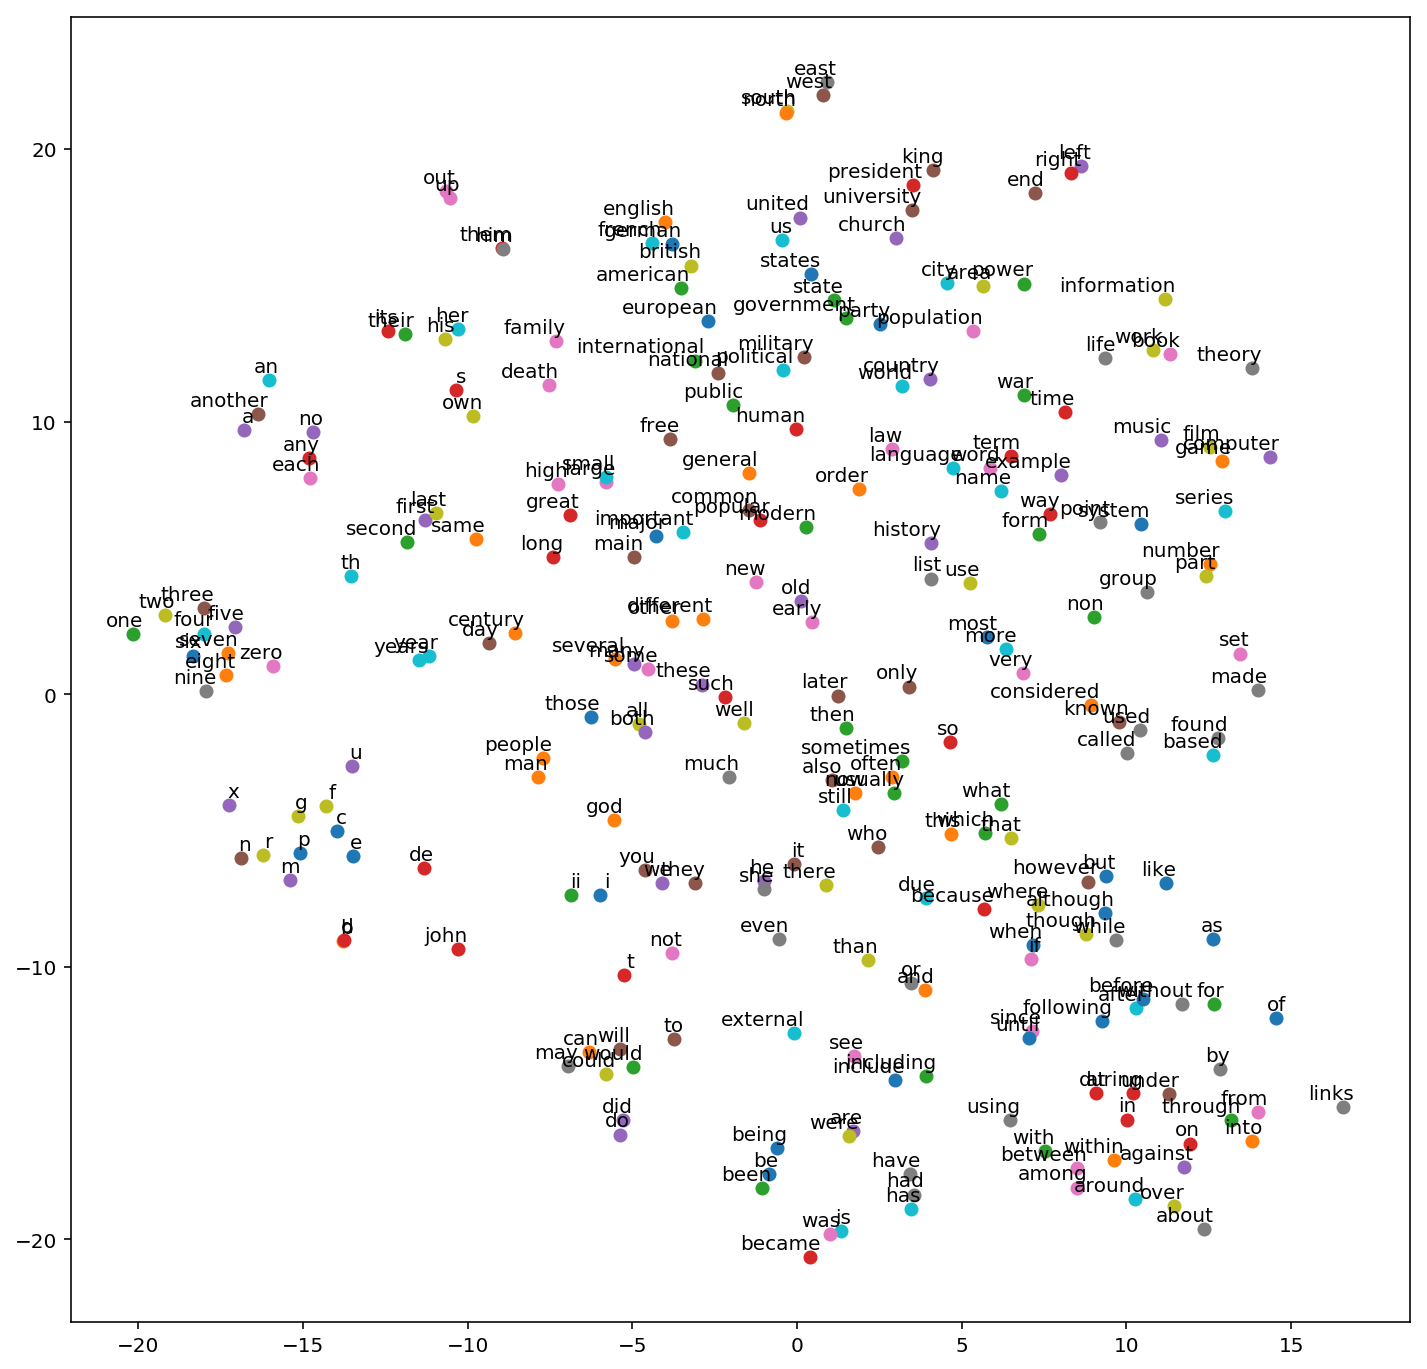

In [37]:
words = [rev_dictionary_[i] for i in range(1, num_points+1)]
cbow_plot(embeddings_2d, words)